# Тестовое задание для компании М

## Задание

Напишите скрипт, который решает задачу:
- Формирует общий датасет, соединяя данные из таблицы обращений на сервере PostgreSQL с данными из файла csv.
- Анализирует собранные данные на предмет их однородности и наличия аномалий.
- Проверяет, существует ли взаимосвязь между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз.

Напишите пояснительную записку, в которой:
- Кратко опишите подход к решению задачи.
- Опишите результаты анализа: существует связь или нет, какие-то дополнительные ее характеристики (сила, статистическая значимость и подобное)


## Загрузка, предобработка и формирование общего датасета

### Загрузка таблиц и первичная предобработка

Импортируем библиотеки

In [1]:
import pandas as pd 
from sqlalchemy import create_engine 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import scipy as sci
from scipy import stats
import json as JSON

Открываем локальный датасет 

In [2]:
path = 'phrases_shows.csv'
wordstat_data = pd.read_csv(path, sep=';')

In [3]:
wordstat_data.head(50)

,date,brand_id,phrase_id,shows
0,2021-06-01,0,0,576
1,2021-06-01,0,1,90
2,2021-06-01,0,2,55
3,2021-06-01,0,3,144
4,2021-06-01,0,4,8
5,2021-06-01,0,5,66
6,2021-06-01,0,6,3
7,2021-06-01,0,7,8115
8,2021-06-01,0,8,1940
9,2021-06-01,0,9,526


In [4]:
wordstat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2668 non-null   object
 1   brand_id   2668 non-null   int64 
 2   phrase_id  2668 non-null   int64 
 3   shows      2668 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 83.5+ KB


Подключаемся к базе данных PostgreSQL. Записываем данные для авторизации в объект `db_config`, и передаем функции `create_engine()` строку для соединения с базой данных. База данных, порт подключения, имя и пароль пользователя предварительно записы в файл `dict.json`

In [5]:
with open('dict.json') as json_data:
    db_config = JSON.load(json_data)

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) # создание соединения

Извлекаем результаты SQL-запроса

In [6]:
query = '''
SELECT *
FROM wordstat_data.communications
'''

In [7]:
data = pd.read_sql_query(query, con = engine) 

In [8]:
data.head(10)

,communication_id,date_time,brand_id,source_type
0,11394944,2021-06-01 00:41:20,1,other
1,11395343,2021-06-01 01:33:09,1,other
2,11397299,2021-06-01 06:02:29,1,other
3,1656035517,2021-06-01 06:09:14,0,other
4,11397353,2021-06-01 06:13:20,1,other
5,11397365,2021-06-01 06:15:35,0,other
6,11397374,2021-06-01 06:16:06,1,other
7,1656040719,2021-06-01 06:20:49,0,other
8,11397383,2021-06-01 06:20:53,1,other
9,11397386,2021-06-01 06:21:29,0,other


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   communication_id  25162 non-null  int64         
 1   date_time         25162 non-null  datetime64[ns]
 2   brand_id          25162 non-null  int64         
 3   source_type       25162 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 786.4+ KB


Приводим некоторые столбцы к формату `datetime`

In [10]:
data['date'] = pd.to_datetime(data['date_time'].dt.date)
wordstat_data['date'] = pd.to_datetime(wordstat_data['date'])

Проверяем пропуски и явные дубликаты

In [11]:
display (data.isna().sum())
display (wordstat_data.isna().sum())

communication_id    0
date_time           0
brand_id            0
source_type         0
date                0
dtype: int64

date         0
brand_id     0
phrase_id    0
shows        0
dtype: int64

In [12]:
display (data.duplicated().sum())
display (wordstat_data.duplicated().sum())
display (data['communication_id'].duplicated().sum())

0

0

0

Явные дубликаты и пропуски в Датафрейме отсутствуют

Проверяем неявные дубликаты 

In [13]:
display (data['brand_id'].unique())
display (data['source_type'].unique())
display (wordstat_data['phrase_id'].unique())

array([1, 0], dtype=int64)

array(['other', 'organic'], dtype=object)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64)

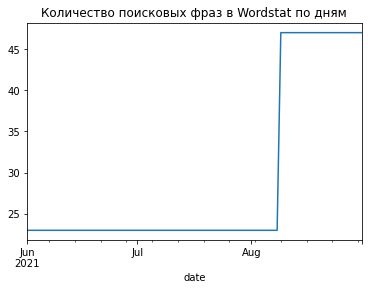

In [14]:
plt.title('Количество поисковых фраз в Wordstat по дням')
wordstat_data.groupby('date').phrase_id.count().plot();

In [15]:
wordstat_data.groupby('date').phrase_id.count().tail(25)

date
2021-08-07    23
2021-08-08    23
2021-08-09    47
2021-08-10    47
2021-08-11    47
2021-08-12    47
2021-08-13    47
2021-08-14    47
2021-08-15    47
2021-08-16    47
2021-08-17    47
2021-08-18    47
2021-08-19    47
2021-08-20    47
2021-08-21    47
2021-08-22    47
2021-08-23    47
2021-08-24    47
2021-08-25    47
2021-08-26    47
2021-08-27    47
2021-08-28    47
2021-08-29    47
2021-08-30    47
2021-08-31    47
Name: phrase_id, dtype: int64

Начиная с 9 августа в датасет добавляются новые фразы с вордстата. Исключим их из таблицы, чтобы они не искажали результаты дальнейшего анализа

In [16]:
wordstat_data = wordstat_data.query('phrase_id <= 22')

In [17]:
print (f'Рассматриваемый период: c {wordstat_data.date.min().date()} по {wordstat_data.date.max().date()}')

Рассматриваемый период: c 2021-06-01 по 2021-08-31


### Объединение датафрейма

Объеденим два датасета в один, агрегируя существующие данные

In [18]:
# Переменные с датафреймами агрегированных значений, которые нужно объединить 
data_agg = data.groupby(['date', 'brand_id', 'source_type'], as_index=False).agg({'communication_id':'count'})
wordstat_data_agg = wordstat_data.groupby(['date', 'brand_id'], as_index=False).agg({'phrase_id':'count', 'shows':'sum'})

merged_data = pd.merge(data_agg, wordstat_data_agg, on=('date','brand_id'))

merged_data.sort_values(by=['date', 'brand_id', 'source_type']).head(30)
merged_data.columns = ['date', 'brand_id', 'source_type', 'leads', 'phrases', 'shows']

merged_data

,date,brand_id,source_type,leads,phrases,shows
0,2021-06-01,0,organic,3,11,11590
1,2021-06-01,0,other,184,11,11590
2,2021-06-01,1,organic,15,12,32641
3,2021-06-01,1,other,201,12,32641
4,2021-06-02,0,organic,5,11,11533
...,...,...,...,...,...,...
362,2021-08-30,1,other,151,12,38541
363,2021-08-31,0,organic,8,11,14999
364,2021-08-31,0,other,146,11,14999
365,2021-08-31,1,organic,10,12,38485


## Анализ данных на наличие аномалий

Определим наличие выбросов в данных, используя диаграммы размаха

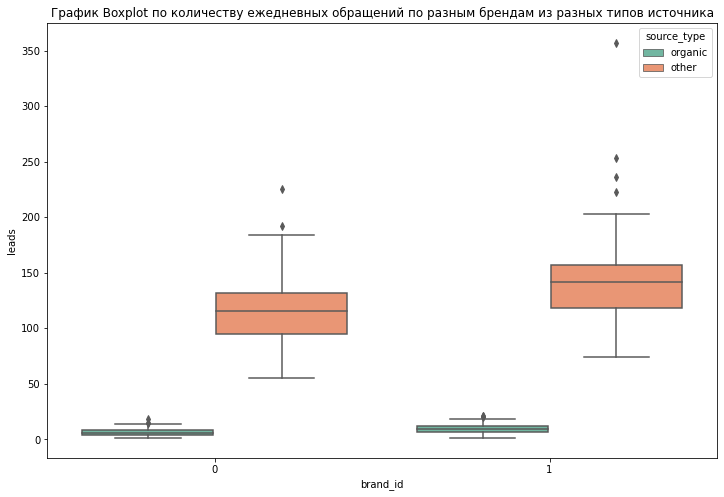

In [19]:
sns.set_palette("Set2")
plt.figure(figsize=(12,8))
plt.title('График Boxplot по количеству ежедневных обращений по разным брендам из разных типов источника')
sns.boxplot(x='brand_id', y='leads', hue='source_type', showfliers=True, data=merged_data);

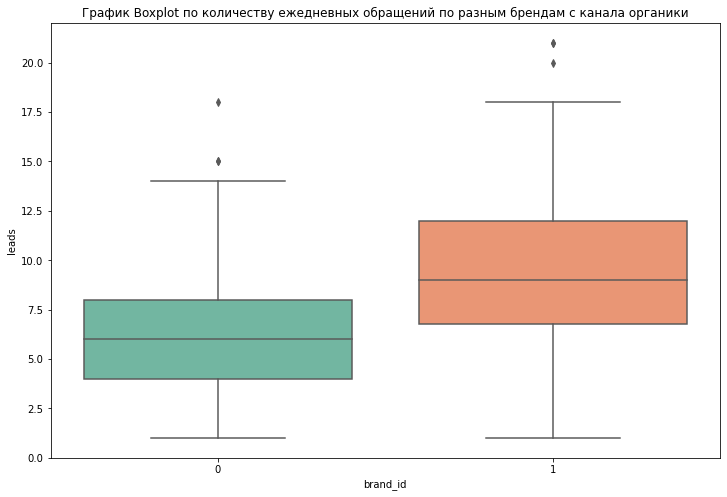

In [20]:
plt.figure(figsize=(12,8))
plt.title('График Boxplot по количеству ежедневных обращений по разным брендам с канала органики')
sns.boxplot(x='brand_id', y='leads', data=merged_data.query('source_type == "organic"'));

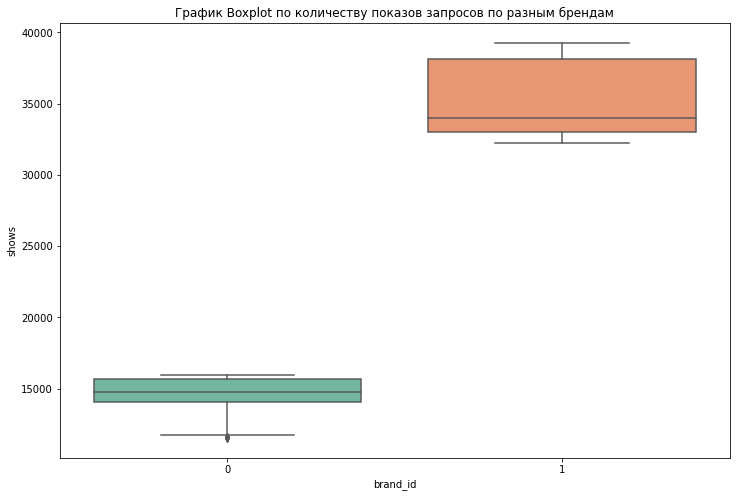

In [21]:
plt.figure(figsize=(12,8))
plt.title('График Boxplot по количеству показов запросов по разным брендам')
sns.boxplot(x='brand_id', y='shows',  showfliers=True, data=merged_data);

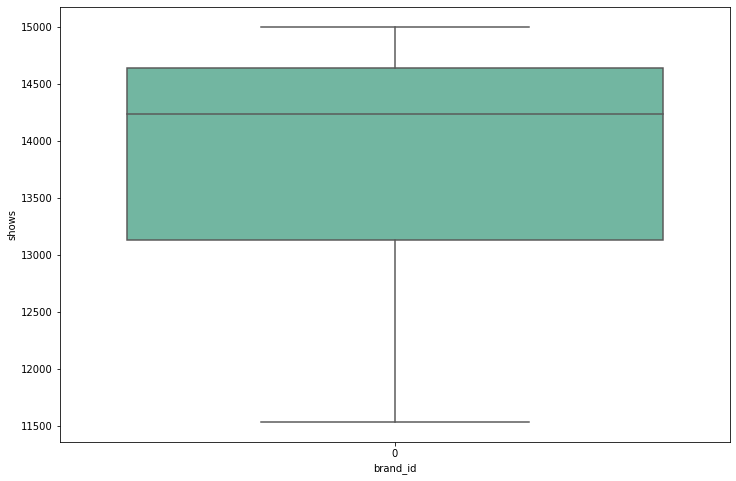

In [22]:
plt.figure(figsize=(12,8))
sns.boxplot(x='brand_id', y='shows', data=merged_data.query('shows < 15000'));

Выбросов и аномалий не наблюдается

Ограничим датафрейм органическим трафиком

In [23]:
merged_data_org = merged_data.query('source_type == "organic"')

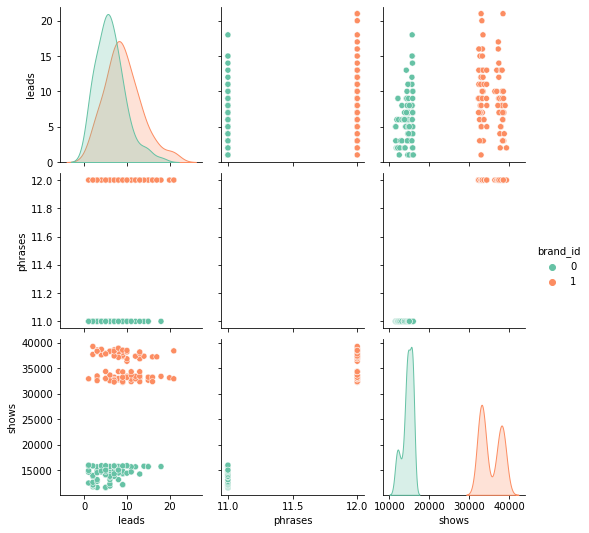

In [24]:
sns.pairplot(merged_data_org, hue="brand_id");

## Исследование взаимосвязи значений

По заданию необходимо оценить взаимосвязь между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз.
Сформулируем нулевую `H_0` и альтернативную `H_a` гипотезы:

`H_0`:  Существует взаимосвязь между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз.

`H_a`: Взаимосвязи между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз нет.

Разделим отфильтрованный органикой датафрейм на 2 таблицы по разным брендам

In [25]:
merged_data_org0 = merged_data_org.query('brand_id == 0').reset_index(drop=True)
merged_data_org1 = merged_data_org.query('brand_id == 1').reset_index(drop=True)

In [26]:
merged_data_org1.isna().sum()

date           0
brand_id       0
source_type    0
leads          0
phrases        0
shows          0
dtype: int64

Так как с Wordstat парсятся информация по показам за предыдущий месяц, то фактически мы можем провести анализ только по двум месяцам, с июня по июль, так как в таблице по июню у нас значения показов запросов за май. То есть все значения смещены на месяц. Учитывая это, посчитаем скользящую сумму обращений. 

Для того, чтобы найти зависимость ежедневного количества обращений с каналов органики от спроса, нам нужно сравнивать сумму обращений за предыдущий месяц и количество показов запросов за предыдущий месяц

In [27]:
merged_data_org1['leads_sum'] = merged_data_org1.leads.rolling(31).sum()
merged_data_org0['leads_sum'] = merged_data_org0.leads.rolling(31).sum()

In [28]:
# усекаем датафрейм до 2 месяцев, в которых есть заполненные скользящие значения параметров
merged_data_org1 = merged_data_org1.dropna().reset_index(drop=True)
merged_data_org0 = merged_data_org0.dropna().reset_index(drop=True)
merged_data_org1

,date,brand_id,source_type,leads,phrases,shows,leads_sum
0,2021-07-01,1,organic,13,12,32353,303.0
1,2021-07-02,1,organic,9,12,32353,297.0
2,2021-07-03,1,organic,1,12,32915,291.0
3,2021-07-04,1,organic,5,12,32967,287.0
4,2021-07-05,1,organic,5,12,32978,279.0
...,...,...,...,...,...,...,...
57,2021-08-27,1,organic,7,12,38352,245.0
58,2021-08-28,1,organic,8,12,38930,241.0
59,2021-08-29,1,organic,2,12,39263,227.0
60,2021-08-30,1,organic,9,12,38541,229.0


Отобразим два графика разброса для исследуемых нами величин для двух разных брендов, а также рассчитаем коэффициент корреляции для данных параметров.

Коэффициент корреляции равен: 0.5649


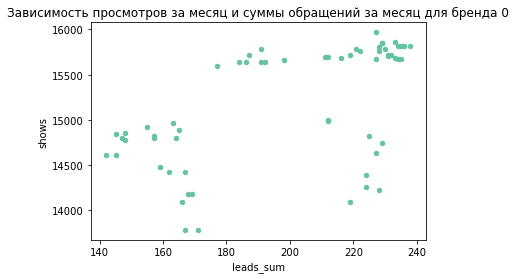

In [29]:
merged_data_org0.plot(x='leads_sum', y='shows', kind='scatter')
plt.title('Зависимость просмотров за месяц и суммы обращений за месяц для бренда 0');
print (f'Коэффициент корреляции равен: {round(merged_data_org0["shows"].corr(merged_data_org0["leads_sum"]), 4)}')

Коэффициент корреляции равен: -0.2987


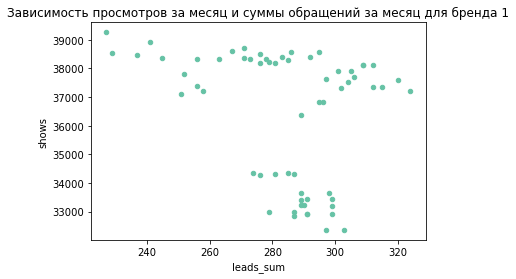

In [30]:
merged_data_org1.plot(x='leads_sum', y='shows', kind='scatter')
plt.title('Зависимость просмотров за месяц и суммы обращений за месяц для бренда 1')
print (f'Коэффициент корреляции равен: {round(merged_data_org1["shows"].corr(merged_data_org1["leads_sum"]), 4)}');

**По полученным визуальным и расчетным данным нельзя сказать, что корреляция между исследуемыми параметрами существенна. Проверим нормально ли распределены параметры, чтобы продолжить дальнейший статистический расчет. Будем использовать Критерий Шапиро-Уилка.**

In [31]:
def Shapiro_Wilk_test(data):
    data = np.array(data)
    result = sci.stats.shapiro(data)
    s_calc = result.statistic    # расчетное значение статистики критерия
    a_calc = result.pvalue    # расчетный уровень значимости
    a_level = 0.05

    print(f"Расчетный уровень значимости: a_calc = {round(a_calc, 8)}")
    print(f"Заданный уровень значимости: a_level = {round(a_level, 8)}")
    
    if a_calc >= a_level:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, 8)} >= a_level = {round(a_level, 8)}" + \
            ", нормальность распределения по критерию Шапиро-Уилка ПРИНИМАЕТСЯ"
    else:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, 8)} < a_level = {round(a_level, 8)}" + \
            ", нормальность распределения по критерию Шапиро-Уилка НЕ ПРИНИМАЕТСЯ"
    print(conclusion_ShW_test)

In [32]:
Shapiro_Wilk_test(merged_data_org0['leads_sum'])
Shapiro_Wilk_test(merged_data_org0['shows'])

Расчетный уровень значимости: a_calc = 6.32e-06
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 6.32e-06 < a_level = 0.05, нормальность распределения по критерию Шапиро-Уилка НЕ ПРИНИМАЕТСЯ
Расчетный уровень значимости: a_calc = 4.96e-06
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 4.96e-06 < a_level = 0.05, нормальность распределения по критерию Шапиро-Уилка НЕ ПРИНИМАЕТСЯ


In [33]:
Shapiro_Wilk_test(merged_data_org1['leads_sum'])
Shapiro_Wilk_test(merged_data_org1['shows'])

Расчетный уровень значимости: a_calc = 0.01974618
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 0.01974618 < a_level = 0.05, нормальность распределения по критерию Шапиро-Уилка НЕ ПРИНИМАЕТСЯ
Расчетный уровень значимости: a_calc = 2e-07
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 2e-07 < a_level = 0.05, нормальность распределения по критерию Шапиро-Уилка НЕ ПРИНИМАЕТСЯ


**У исходных данных распределение не равно нормальному, что не позволяет нам в дальнейшем пользоваться статистическим инструментарием для оценивания статистической значимости по коэффициенту корреляции Пирсона и дальнейшей проверки гипотезы.**

Посчитаем плотности распределения по дням обращений и показов запросов, и покажем на графике 

In [34]:
merged_data_org1['shows_ratio'] = merged_data_org1.apply(lambda row: row['shows'] / merged_data_org1.shows.sum(), axis=1)
merged_data_org1['leads_ratio'] = merged_data_org1.apply(lambda row: row['leads_sum'] / merged_data_org1.leads_sum.sum(), axis=1)

In [35]:
merged_data_org0['shows_ratio'] = merged_data_org0.apply(lambda row: row['shows'] / merged_data_org0.shows.sum(), axis=1)
merged_data_org0['leads_ratio'] = merged_data_org0.apply(lambda row: row['leads_sum'] / merged_data_org0.leads_sum.sum(), axis=1)

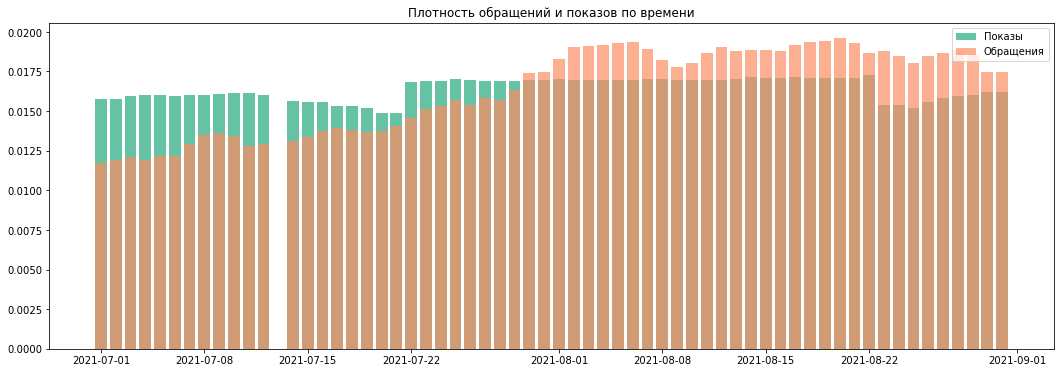

In [36]:
plt.figure(figsize=(18, 6))
plt.bar(height=merged_data_org0['shows_ratio'], x=merged_data_org0['date'], alpha=1, label='Показы')
plt.bar(height=merged_data_org0['leads_ratio'], x=merged_data_org0['date'], alpha=0.7, label='Обращения')
plt.legend(loc='upper right')
plt.title('Плотность обращений и показов по времени')
plt.show()

**Никакой связи визуально также не наблюдается. По результату проведенного анализа отвергаем нулевую гипотезу. Взаимосвязи между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз обнаружено не было.**

Для улучшения существующей модели сбора и предобработки данных, опционально, можно:
- Для категорий брендов собирать данные показов по одинаковому количеству запросов
- Выгружать вместе с id запросов, строчные значения. Это улучшит качество анализа и позволит фильтровать нерелевантные или выбивающиеся запросы 
- Проверить возможность парсинга количества просмотров по неделям для более точной обработки результатов. Wordstat группирует по неделям в т.ч.
- Продолжить сбор данных по месяцам для увеличения горизонта анализа: возможно это поможет в будущем обнаружить корреляцию у исследуемых параметров, а также даст возможность более эффективно считать и сравнивать между собой скользящую корреляцию.